# Explanation

For a real-valued discrete-time non-negative random process $X_t$, the code below constructs an upper confidence sequence for the inverse expectile function $\overline{\mathcal{E}^{-1}_t}(z)$ of the average historical conditional distribution, where the expectile function is defined as $$
\begin{aligned}
\overline{\mathcal{E}_t}(\tau) &\doteq \arg \min_z \sum_{s \leq t} \mathbb{E}_{s-1}\left[\left( (1 - \tau) 1_{X_s \leq z} + \tau 1_{X_s > z} \right) \left(z - X_s\right)^2 \right],
\end{aligned}
$$
and the upper CS on $\overline{\mathcal{E}^{-1}_t}(z)$ is simultaneously valid for all times and all $z \geq 0$.  This yields a lower CS on the expectile function via $$
\begin{aligned}
\overline{\mathcal{E}_t}(\tau) &\geq \min_z \left\{ z \left| \,\lnot \left( \overline{\mathcal{E}^{-1}_t}(z) \leq \tau \right) \right. \right\}.
\end{aligned}
$$

# Derivation

## Step 0: Stationary condition bound arithmetic

<!----
$$
\begin{aligned}
s(v, \tau) &= \mathbb{E}\left[ \left( (1 - \tau) 1_{Y \leq v} + \tau 1_{Y > v} \right) \left(v - Y\right)^2 \right] \\
&= \mathbb{E}\left[ \left( \tau + \left(1 - 2 \tau\right) 1_{Y \leq v} \right) \left(v - Y\right)^2 \right] \\
0 = \nabla_v s(v^*, \tau) &= 2 \mathbb{E}\left[ \left( \tau + \left(1 - 2 \tau\right) 1_{Y \leq v^*} \right) \left(v^* - Y\right) \right] \\
\tau \mathbb{E}\left[Y\right] &= \tau v^* + (1 - 2 \tau) \mathbb{E}\left[1_{Y \leq v^*} \left(v^* - Y\right) \right] \\
\end{aligned}
$$
---->

For fixed $z \geq 0$, the first order condition indicating the associated $\overline{\mathcal{E}^{-1}_t}(z)$ is $$
\begin{aligned}
\overline{\mathcal{E}^{-1}_t}(z) \sum_{s \leq t} \mathbb{E}_{s-1}\left[X_s\right] &= \overline{\mathcal{E}^{-1}_t}(z) z + \left(1 - 2 \overline{\mathcal{E}^{-1}_t}(z)\right) \sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq z} \left(z - X_s\right) \right].
\end{aligned}
$$ The left-hand side includes the running mean for which [DDRM](https://arxiv.org/abs/2210.11133) provides a lower CS.  The right-hand side includes a bounded random variable for which we can produce a CS, resulting in $$
\begin{aligned}
0 \leq a_t &\leq \sum_{s \leq t} \mathbb{E}_{s-1}\left[X_s\right], \\
0 \leq b_t &\leq \sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq z} \left(z - X_s\right) \right] \leq c_t, & \left(c_t > b_t\right) \\
\overline{\mathcal{E}^{-1}_t}(z) &\leq \begin{cases}
\frac{c_t}{a_t + 2 c_t - z} & a_t \geq z \\
\frac{b_t}{a_t + 2 b_t - z} & \left(0 < a_t < z\right) \land \left(a_t + 2 b_t > z\right)
\end{cases}.
\end{aligned}
$$
<!---
damax = MaxValue[{ \[Tau], \[Tau] \[Mu] == \[Tau] v + (1 - 2 \[Tau]) \[Zeta], \[Mu] >= a >= 0, 0 <= b <=  \[Zeta] <= c, v >= 0, 0 <= \[Tau] }, { \[Tau], \[Mu], \[Zeta] } ];
Simplify@Refine[damax, a >= v >= 0 && v >= c > b > 0]
Simplify@Refine[damax, 0 < a < v  && v >= c > b > 0 && a + 2 b > v]
--->

## Step 1: DDRM lower CS for $\sum_{s \leq t} \mathbb{E}_{s-1}\left[X_s\right]$

This is the Heavy NSM from [Mineiro](https://arxiv.org/abs/2210.11133), modified to work with a mean in $[0, \infty)$, composed with Adagrad and an $L^*$ bound, and mixed with DDRM.

Let $X_t$ be a non-negative real-valued discrete-time random process, let $\lambda \in [0, 1)$ be a fixed scalar bet, and let $\hat{X}_t \in [0, \frac{1}{2} \lambda^{-1}]$ be a predictable sequence.  Then $$
\begin{aligned}
E_t(\lambda) &\doteq \exp\left( \lambda \left(\sum_{s \leq t} \hat{X}_s - \mathbb{E}_{s-1}\left[X_s\right]\right) + \sum_{s \leq t} \log\left(1 + \lambda \left(X_s - \hat{X}_s\right) \right) \right) \\
&= \exp\left( \lambda \left(\sum_{s \leq t} X_s - \mathbb{E}_{s-1}\left[X_s\right]\right) - \sum_{s \leq t} \underbrace{\left( \lambda \left(X_s - \hat{X}_s\right) - \log\left(1 + \lambda \left(X_s - \hat{X}_s\right) \right) \right)}_{\doteq h\left(\lambda \left(X_s - \hat{X}_s\right)\right)} \right) \\
&= \exp\left( \lambda \left(\sum_{s \leq t} X_s - \mathbb{E}_{s-1}\left[X_s\right]\right) - \sum_{s \leq t} h\left(\lambda \left(X_s - \hat{X}_s\right)\right) \right) \\
&\geq \exp\left( \lambda \left(\sum_{s \leq t} X_s - \mathbb{E}_{s-1}\left[X_s\right]\right) - \left( \sum_{s \leq t} h\left(\lambda \left(X_s - \hat{X}_t^*\right)\right) \right) - \text{Reg}(t) \right) & \left(\dagger\right) \\
&= \exp\left( \lambda \left(t \hat{X}_t^* - \sum_{s \leq t} \mathbb{E}_{s-1}\left[X_s\right]\right) + \sum_{s \leq t} \log\left(1 + \lambda \left(X_s - \hat{X}_t^*\right) \right) - \text{Reg}(t) \right),
\end{aligned}
$$ where for $(\dagger)$ we use a no-regret learner on $h()$ with regret $\text{Reg}(t)$ to any constant prediction $\hat{X}_t^* \in [0, \frac{1}{2} \lambda^{-1}]$.  The function $h()$ is $M$-smooth with $M = 4 \lambda^2$ (see [Lemma 9](https://web.stanford.edu/~sidford/courses/20fa_opt_theory/sidford_mse213_2020fa_chap_5_extensions.pdf)) so we can get an [$L^*$ bound](https://parameterfree.com/2019/09/20/adaptive-algorithms-l-bounds-and-adagrad/) of $$
\begin{aligned}
\text{Reg}(t) &= 4 + 4 \sqrt{\sum_{s \leq t} h\left(\lambda \left(X_s - \hat{X}_t^*\right)\right)},
\end{aligned}
$$ thus essentially our variance process is inflated by a square-root.

We can compete with any in-hindsight prediction, if we choose to compete with the clipped running mean $\overline{X_t} = \min\left(\frac{1}{2} \lambda^{-1}, \frac{1}{t} \sum_{s \leq t} X_t\right)$ then we end up with $$
\begin{aligned}
E_t(\lambda) &\geq \exp\left(
\left(\min\left(\frac{t}{2}, \lambda \sum_{s \leq t} X_s\right) - \mathbb{E}_{s-1}\left[X_s\right]\right) + \sum_{s \leq t} \log\left(1 + \lambda \left(X_s - \overline{X_t}\right) \right)  - \text{Reg}(t)
\right),
\end{aligned}
$$ and furthermore $$
\begin{aligned}
\sum_{s \leq t} \log\left(1 + \lambda \left(X_s - \overline{X_t}\right) \right) &\leq \lambda \left(\sum_{s \leq t} X_s - t \overline{X_t}\right)
\end{aligned}
$$ which is useful for early terminating discrete mixtures.  To minimize computational overhead, we can lower bound $\log(a + b)$ for $b \geq 0$ using strong concavity, $$
\begin{aligned}
(1 + k)^{n_l} = z_l &\leq z < z_u = (1 + k) z_l = (1 + k)^{n_l+1}, \\
f(z) &\doteq \log\left(1 + \lambda \left(z - \hat{X}_t^*\right) \right), \\
f(z) &\geq \alpha f(z_l) + (1 - \alpha) f(z_u) + \frac{1}{2} \alpha (1 - \alpha) m(z_l), \\
\alpha &\doteq \frac{z_u - z}{z_u - z_l}, \\
m(z_l) &\doteq \left( \frac{k z_l \lambda}{k z_l \lambda + 1 - \lambda \hat{X}_t^*} \right)^2.
\end{aligned}
$$

## Full CS for $\sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq z} \left(z - X_s\right) \right]$

This is [empirical Bernstein supermartingale](https://arxiv.org/abs/1810.08240) combined with FTL, applied to either $Y_t = 1_{X_t \leq z} (z - X_t)$ or $Y_t = z - 1_{X_t \leq z} (z - X_t)$.

For fixed $z$, let $Y_t \in [0, z]$ be a discrete-time random process, let $\hat{Y}_t \in [0, z]$ be a predictable sequence, and let $\lambda \in [0, 1)$ be a fixed scalar bet.  Then $$
\begin{aligned}
E_t(\lambda) &\doteq \exp\left( \lambda z^{-1} \left(\sum_{s \leq t} \hat{Y}_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) + \sum_{s \leq t} \log\left(1 + \lambda z^{-1} \left(Y_s - \hat{Y}_s\right) \right) \right) \\
\end{aligned}
$$ is a supermartingale.  Manipulating $$
\begin{aligned}
E_t(\lambda) &\doteq \exp\left( \lambda z^{-1} \left(\sum_{s \leq t} Y_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) - \sum_{s \leq t} \underbrace{\left( \lambda z^{-1} \left(Y_s - \hat{Y}_s\right) - \log\left(1 + \lambda z^{-1} \left(Y_s - \hat{Y}_s\right) \right) \right)}_{\doteq h\left(\lambda z^{-1} \left(Y_s - \hat{Y}_s\right)\right)} \right) \\
&\geq \exp\left( \lambda z^{-1} \left(\sum_{s \leq t} Y_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) - h(-\lambda) z^{-2} \sum_{s \leq t} \left(Y_s - \hat{Y}_s\right)^2\right) &  \left(\text{Fan}\right) \\
&\geq \exp\left( \lambda z^{-1} \left(\sum_{s \leq t} Y_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) - h(-\lambda) z^{-2} \left( \text{Reg}(t) + \sum_{s \leq t} \left(Y_s - Y^*_t\right)^2\right) \right) & \left(\dagger\right), 
\end{aligned}
$$ where for $(\dagger)$ we use a no-regret learner on squared loss on feasible set $[0, z]$ with regret $\text{Reg}(t)$ to any constant in-hindsight prediction $\hat{Y}_t^* \in [0, z]$. [FTL](https://www.cs.ubc.ca/labs/lci/mlrg/slides/2019_summer_3_follow_the_leader.pdf) yields $\text{Reg}(t) \leq 8 z^2 \left(1 + \log(t)\right)$.  We will compete with $Y^*_t = \frac{1}{t} \sum_s Y_s$.

**Analytical Mixture**: Define $$
\begin{aligned}
\hat{\mu}_t &\doteq \frac{1}{t} z^{-1} \sum_{s \leq t} Y_s, \\
\mu_t &\doteq \frac{1}{t} z^{-1} \sum_{s \leq t} \mathbb{E}_{s-1}\left[Y_s\right], \\
v_t &\doteq \frac{1}{t} z^{-2} \left(\text{Reg}(t) + \sum_{s \leq t} \left(Y_s - \hat{Y}^*_t\right)^2 \right).
\end{aligned}
$$  Then $$
\begin{aligned}
W_t(b; v_t, \hat{\mu}_t, \mu_t) &= \int_0^1 d\text{Beta}(\lambda; 1, b)\ \exp\left(\lambda t \left(v_t + \hat{\mu}_t - \mu_t\right)\right) \left(1 - \lambda\right)^{t v_t} \\
&= b \int_0^1 d\lambda \exp\left(\lambda t \left(v_t + \hat{\mu}_t - \mu_t\right)\right) \left(1 - \lambda\right)^{t v_t + b - 1} \\
&= \left(\frac{b}{t v_t + b}\right) \left(\frac{\Gamma(c)}{\Gamma(a) \Gamma(c-a)} \int_0^1 du \exp\left(\xi u\right) u^{a-1} (1 - u)^{c-a-1}\right)\biggr|_{\substack{a=1 \\ c=t v_t + b + 1 \\ \xi= t \left(v_t + \hat{\mu}_t - \mu_t\right)}} \\
&= \left(\frac{b}{b + t v_t}\right) {}_1F_1\left(1, t v_t + b + 1, t \left(v_t + \hat{\mu}_t - \mu_t\right)\right) \\
&= \frac{b \exp\left(t \left(v_t + \hat{\mu}_t - \mu_t \right)\right)}{\left(t \left(v_t + \hat{\mu}_t - \mu_t \right)\right)^{b+t v_t}} \Gamma\left(b + t v_t, 0, t \left(v_t + \hat{\mu}_t - \mu_t \right)\right) & \left(v_t + \hat{\mu}_t - \mu_t > 0\right) \\
\log W_t(b; v_t, \hat{\mu}_t, \mu_t) &= \log(b) - \log(b + t v_t) + \left(\frac{t}{1 + b + t v_t}\right) \epsilon + O(\epsilon^2) \biggr|_{\epsilon=v_t + \hat{\mu_t} - \mu_t}
\end{aligned}
$$ where $\Gamma(a, z_0, z_1)$ is the [Mathematica version](https://reference.wolfram.com/language/ref/Gamma.html) and ${}_1F_1(\ldots)$ is [the Kummer confluent hypergeometric function](https://reference.wolfram.com/language/ref/Hypergeometric1F1.html) which is always real-valued.

For a lower bound we just replace $Y_t \leftarrow z - Y_t$ in the derivation resulting in the same $v_t$ and $$
\begin{aligned}
W_t(b; v_t, \hat{\mu}_t, \mu_t) &= \left(\frac{b}{b + t v_t}\right) {}_1F_1\left(1, t v_t + b + 1, t \left(v_t + \mu_t - \hat{\mu}_t\right)\right) \\
&= \frac{b \exp\left(t \left(v_t + \mu_t - \hat{\mu}_t \right)\right)}{\left(t \left(v_t + \mu_t - \hat{\mu}_t \right)\right)^{b+t v_t}} \Gamma\left(b + t v_t, 0, t \left(v_t + \mu_t - \hat{\mu}_t \right)\right) & \left(v_t + \mu_t - \hat{\mu}_t > 0\right) \\
\log W_t(b; v_t, \hat{\mu}_t, \mu_t) &= \log(b) - \log(b + t v_t) + \left(\frac{t}{1 + b + t v_t}\right) \epsilon + O(\epsilon^2) \biggr|_{
\epsilon=v_t + \mu_t - \hat{\mu_t}}
\end{aligned}
$$

## Step 2: Use a countably infinite collection of intervals

The $n$-th intervals models $\sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq u(n)}\right]$ via the test supermartingale.  Let $\alpha(n) \geq 0$ define a (decreasing) assignment of probability with $1 \geq \sum_{n=1}^\infty \alpha(n)$ for a union bound, e.g., $\alpha(n) = 6 / (\pi^2 n^2)$.

Although we have a countable infinite number of intervals covered with a union bound, there is no point in evaluating past the point where the bounds can improve.  Specifically, if all counts are to the left of the probe, there is no point in further refining the upper boundary.

# Code

In [1]:
class StreamingEmpBernECDF(object):
    class Frozen(object):
        def __init__(self, rawsd, tot):
            from sortedcontainers import SortedDict
            super().__init__()
        
            self.sd = SortedDict()
            
            # TODO: Kahan summation
            cumsum = {
                'sum_s W_s 1_{X_s <= z}': 0,
                'sum_s W_s X_s 1_{X_s <= z}': 0,
                'sum_s W_s^2 1_{X_s <= z}': 0,
                'sum_s W_s^2 X_s^2 1_{X_s <= z}': 0,
            }
            sumy, sumysq = 0, 0
            for k, v in rawsd.items():
                cumsum['sum_s W_s 1_{X_s <= z}'] += v[0]
                cumsum['sum_s W_s X_s 1_{X_s <= z}'] += v[0] * k
                cumsum['sum_s W_s^2 1_{X_s <= z}'] += v[1]
                cumsum['sum_s W_s^2 X_s^2 1_{X_s <= z}'] += v[1] * k**2
                
                # Y = W_s 1_{X_s <= z} (z - X_s)
                # Y^2 = W_s^2 1_{X_s <= z} (z^2 - 2 z X_s + X_s^2)
                
                sumy = k * cumsum['sum_s W_s 1_{X_s <= z}'] - cumsum['sum_s W_s X_s 1_{X_s <= z}']
                sumysq = (
                      k**2 * cumsum['sum_s W_s^2 1_{X_s <= z}'] 
                    - 2 * k * cumsum['sum_s W_s X_s 1_{X_s <= z}'] 
                    + cumsum['sum_s W_s^2 X_s^2 1_{X_s <= z}']
                )
                assert sumy >= 0, sumy
                assert sumysq >= 0, sumysq
                
                self.sd[k] = (sumy, sumysq)
            
            self.cumsum = (sumy, sumysq)
            self.tot = tot

        def __call__(self, H):
            if H is None:
                return self.tot
            
            hgeindex = self.sd.bisect_right(H)
            if hgeindex != len(self.sd):
                _, Hcnt = self.sd.peekitem(hgeindex)
            else:
                Hcnt = self.cumsum
                
            return Hcnt

    def __init__(self):
        from sortedcontainers import SortedDict
        super().__init__()
        
        self.sd = SortedDict()
        self.tot = 0
        
    def addobs(self, r, w):
        from numbers import Number
        assert isinstance(r, Number), r
        assert isinstance(w, Number), w
        assert w >= 0
        
        # TODO: Kahan summation
        self.sd.setdefault(r, [0, 0])
        self.sd[r][0] += w
        self.sd[r][1] += w**2
        self.tot += 1
        
    def freeze(self):
        return self.Frozen(self.sd, self.tot)

class LogApprox(object):
    def __init__(self, k):
        from math import sqrt
        from numbers import Number

        super().__init__()
        
        assert isinstance(k, Number), k
        assert 0 < k < 1
        
        self.k = k
        self.stats = {}
        self.sumz = 0
        self.tot = 0
                
    def __le__(self, other):
        if self.k != other.k:
            raise NotImplementedError
            
        return self.sumz <= other.sumz
            
    def __iadd__(self, other):
        if self.k != other.k:
            raise NotImplementedError
        
        for k, v in other.stats.items():
            self.stats.setdefault(k, 0)
            self.stats[k] += v
            
        self.sumz += other.sumz
        self.tot += other.tot
        
        return self
    
    def __add__(self, other):
        import copy
        rv = copy.deepcopy(self)
        rv += other
        return rv

    def sumy(self):
        return self.sumz
    
    def yhat(self, lam):
        return 0 if self.tot == 0 else min(0.5/lam, self.sumz / self.tot)

    def getLowerBoundWithRegret(self, lam):
        from math import log1p, sqrt, inf
        
        assert 0 < lam < 1
        
        rv = 0
        yhat = self.yhat(lam)
        hemp = 0
        
        for (what, z), v in self.stats.items():
            assert what == 'f' or what == 'm'
            if what == 'f':
                dalog = log1p(lam * (z - yhat))
                rv += v * dalog
                hemp += v * (lam * (z - yhat) - dalog)
            elif what == 'm':
                rv += v * ( (self.k * z * lam) / (self.k * z * lam + 1 - lam * yhat) )**2
                
        lstarregret = 4 + 4 * sqrt(hemp)
            
        return rv - lstarregret
        
    def update(self, z, c):
        from numbers import Number
        assert isinstance(z, Number), z
        assert z >= 0
        assert isinstance(c, Number), c
        assert c >= 0
        
        # TODO: Kahan summation
        if z == 0:
            self.stats.setdefault(('f', z), 0)
            self.stats[('f', z)] += c
        else:
            from math import log, log1p, floor
            n = floor(log(z) / log1p(self.k))
            zl = (1 + self.k)**n
            zu = (1 + self.k)**(n+1)
            alpha = (zu - z) / (zu - zl)
            if alpha > 0:
                self.stats.setdefault(('f', zl), 0)
                self.stats[('f', zl)] += alpha * c
            if alpha < 1:
                self.stats.setdefault(('f', zu), 0)
                self.stats[('f', zu)] += (1 - alpha) * c
            if alpha > 0 and alpha < 1:
                self.stats.setdefault(('m', zl), 0)
                self.stats[('m', zl)] += alpha * (1 - alpha) * c
            
        self.sumz += c * z
        self.tot += c
                                
        return self

class DDRM(object):
    def __init__(self, *, eta=0.95, r=2, lambdamax=1/2, xi=8/5):
        from math import exp
        from mpmath import fp 
        from scipy.special import lambertw
        
        super().__init__()
        
        assert 0 < eta < 1
        assert 1 < r
        assert 0 < lambdamax <= 1 + lambertw(-exp(-2))
        assert 1 < xi
        
        self.eta = eta
        self.r = r
        self.lambdamax = lambdamax
        self.xi = xi
        self.scalefac = 1/2 * (xi - 1) * (1 + fp.polylog(r, eta) / (eta * fp.zeta(r)))
    
    def get_lam(self, j):
        return self.lambdamax / self.xi**(1/2 + j)

    def get_w(self, j):
        return self.scalefac / self.xi**(1 + j)
    
    def get_remaining_w_ub(self, j):
        # Sum[scale / \[Xi]^(1+k), { k, j + 1, Infinity }]
        return self.scalefac * (self.xi - 1) / self.xi**(1 + j)

In [2]:
def getDDRMCSLowerBound(logapprox, t, logp):
    from scipy.optimize import root_scalar
    
    assert t >= 1
    assert t == logapprox.tot
    thres = -logp
    ddrm = DDRM()
    lams = [ ddrm.get_lam(j) for j in range(2) ]
    vs = [ logapprox.getLowerBoundWithRegret(lam) for lam in lams ]
    ws = [ ddrm.get_w(j) for j, _ in enumerate(lams) ]
    yhats = [ logapprox.yhat(lam) for lam in lams ]

    def logwealth(mu):
        from scipy.special import logsumexp
        nonlocal lams
        nonlocal vs
        nonlocal ws
        nonlocal yhats
        
        a = [ lamj * t * (yhat - mu) + vj
              for lamj, vj, yhat in zip(lams, vs, yhats)
            ] 
        
        while True:
            logwlb = logsumexp(a=a, b=ws)

            # lower bound
            if logwlb >= thres:
                assert True, {
                    'a': a,
                    'ws': ws, 
                    'logwlb': logwlb, 
                    'thres': thres, 
                    'yhats': yhats,
                    'mu': mu,
                    't': t,
                }
                return logwlb
            
            # upper bound
            j = len(lams)
            ubvar = logapprox.sumy() - t * yhats[-1]
            logwub = logsumexp(a = [lams[-1] * t * (yhats[-1] - mu) + lams[-1] * ubvar] + a,
                               b = [ddrm.get_remaining_w_ub(j)] + ws)
            if logwub <= thres:
                assert True, {
                    'logwub': logwub, 
                    'thres': thres, 
                    'ws': ws, 
                    'yhats': yhats,
                    'mu': mu,
                    'lams[-1] * t * (yhats[-1] - mu)': lams[-1] * t * (yhats[-1] - mu),
                    'wub': ddrm.get_remaining_w_ub(j),
                }
                return logwub
            
            lams += [ ddrm.get_lam(j) ]
            vs += [ logapprox.getLowerBoundWithRegret(lams[-1]) ]
            ws += [ ddrm.get_w(j) ]
            yhats += [ logapprox.yhat(lams[-1]) ]
            a += [ lams[-1] * t * (yhats[-1] - mu) + vs[-1] ]
    
    mumin = 0
    mumax = logapprox.sumy()/t
    if mumax <= mumin or logwealth(mumin) <= thres:
        return mumin
    
    if logwealth(mumax) >= thres:
        return mumax
    
    res = root_scalar(f=lambda mu: logwealth(mu) - thres, bracket=[mumin, mumax], xtol=max(1e-6, 1/(2*t)))
    assert res.converged
    return res.root

def logunnormalizedgamma(k, x):
    from math import log
    from scipy.special import gammainc, loggamma
    
    try:
        rv = loggamma(k) + log(gammainc(k, x))
    except:
        rv = -x + (k - 2) * log(z) + log(k + x - 1) # + O(1/x)

    return rv

def getGammaCSLowerBound(sumy, sumysq, z, t, logalpha):
    from math import log, sqrt
    from scipy.optimize import root_scalar
    
    assert z > 0
    assert 0 <= sumy, (sumy, sumysq, z, t)
    assert 0 <= sumysq,  (sumy, sumysq, z, t)
    assert t >= 1
    assert logalpha <= 0
        
    b = 1
    thres = -logalpha
    tvar = (sumysq - sumy**2 / t) / z**2   # optimal empirical variance
    tvar += 8 * (log(t) + 1)               # FTL regret
    tmuhat = sumy/z
    
    def logwealth(mu):
        tz = tvar + tmuhat - t * mu
        assert tz >= 0
        
        k = tz / (1 + b + tvar)
        bptv = b + tvar
        
        if k <= 1e-2:
            return log(b) - log(bptv) + k + (bptv / (4 + 2 * bptv)) * k**2 # + O(k^3)
        else:
            return log(b) + tz - bptv * log(tz) + logunnormalizedgamma(bptv, tz)
    
    mumin = 0
    mumax = min(1, sumy/(t*z))
    if mumax <= mumin or logwealth(mumin) <= thres:
        return z * mumin
    
    if logwealth(mumax) >= thres:
        return z * mumax
    
    res = root_scalar(f=lambda mu: logwealth(mu) - thres, bracket=[mumin, mumax])
    assert res.converged
    return z * res.root

def getZeroInfUpperBound(probe, mulower, counts, conf):
    from math import log, floor, pi, inf
    
    assert 0 <= probe, probe
    
    bt, ct = 0, 1
    ub = 1 if mulower < probe else ct / (mulower + 2 * ct - probe)
    
    log6opsq = log(6/pi**2)
    logconf = log(conf)
    
    t = counts(None)
    sumcprobe, _ = counts(probe)
    
    # technically depth range(1, infinity)
    # in practice we have finite numerical precision
    for depth in range(1, 100):
        # grid is (k / 2**depth) for k in [1, \ldots, 4**depth]
        # even values of k less than 2**depth are duplicates from prior grids
        #   this is half of the points from the previous grid = (1/2) 4**(depth-1) = (1/8) 4**depth
        #   hence size of grid not already covered is (7/8) 4**depth
        
        logp = log6opsq - 2 * log(depth) - (depth * log(4) + log(7/8))
        #                 ^--- union bound over depth
        #                                   ^--- shared by (7/8) 4**depth
        
        klower = floor(2**depth * probe)
        if klower < 4**depth:
            if mulower < probe and (klower % 2 == 1 or klower >= 2**depth):
                zlower = klower / 2**depth
                assert zlower <= probe
                sumclower, sumclowersq = counts(zlower)
                bt = max(bt, getGammaCSLowerBound(sumclower, sumclowersq, zlower, t, logp + logconf))
                if mulower + 2 * bt > bt + probe: # NB: avoid division by zero
                    ub = min(ub, bt / (mulower + 2 * bt - probe))

                if sumclower >= sumcprobe:
                    break

            elif mulower >= probe and (klower % 2 == 0 or klower >= 2**depth):
                zupper = (klower + 1) / 2**depth
                assert zupper >= probe
                sumcupper, sumcuppersq = counts(zupper)
                # sum(z - y)^2 = t * z^2 - 2 * z * sumy + sumysq
                revsumcupper = zupper * t - sumcupper
                revsumcuppersq = sumcuppersq - 2 * zupper * sumcupper + t * zupper**2
                ct = min(ct, zupper - getGammaCSLowerBound(revsumcupper, revsumcuppersq, zupper, t, logp + logconf))
                ub = min(ub, ct / (mulower + 2 * ct - probe))
                
                if sumcupper <= sumcprobe:
                    break
            
    return ub

# Examples
These are stationary simulations, so they don't show the full power of the technique.

In [3]:
def plotit(data, true):
    from math import sqrt, log
    from scipy.interpolate import interp1d
    import matplotlib.pyplot as plt
    import numpy as np
    import time
    
    conf = 0.05
    
    T = len(data)    
    nxvals = 1000

    ecdfx = np.sort(data)
    ecdfy = np.arange(1, len(data)+1)/float(len(data))
    probevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=ecdfy, fp=ecdfx, left=0, right=1)

    exactinvexpectiley = np.array([ true.invexpectile(x) for x in probevals ])
    
    plt.figure()
    plt.gcf().set_size_inches(16, 8)
    
    lapprox = LogApprox(k=0.25)
    counts = StreamingEmpBernECDF()
    for x in data:
        lapprox.update(x, 1)
        counts.addobs(x, 1)
    mulower = getDDRMCSLowerBound(lapprox, T, conf / 2)
    print(f'mulower = {mulower}')
    icey = counts.freeze()
    
    from math import pi, log
    
    # tree
    start = time.time()
    ubinvexpectiley = np.array([ getZeroInfUpperBound(x, mulower, icey, conf / 2) for x in probevals ])
    end = time.time()

    # TODO: expectiles are uniformly convex so this presumably exhibits uniform convergence, could compare to rate
    plt.plot(probevals, ubinvexpectiley - exactinvexpectiley, label='inv expf ub minus exact')
    plt.title(f'difference between bounds and exact inverse expectile function for {true.desc}')
    plt.legend()
    #plt.savefig(f'fixedvaluequantiletreedelta.beta({betaa},{betab}).png', bbox_inches='tight')    

    plt.figure()
    plt.gcf().set_size_inches(16, 8)
    plt.plot(probevals, exactinvexpectiley, label='exact inv expf')
    plt.plot(probevals, ubinvexpectiley, label='inv expf ub')
    plt.title(f'ubcdf calc time for T={T} at {nxvals} evenly spaced x-values: {end-start:.3f} s')
    #plt.savefig(f'fixedvaluequantiletreecdf.beta({betaa},{betab}).png', bbox_inches='tight')
    plt.legend()

### Beta(1,1) distribution

mulower = 0.4946201320826525


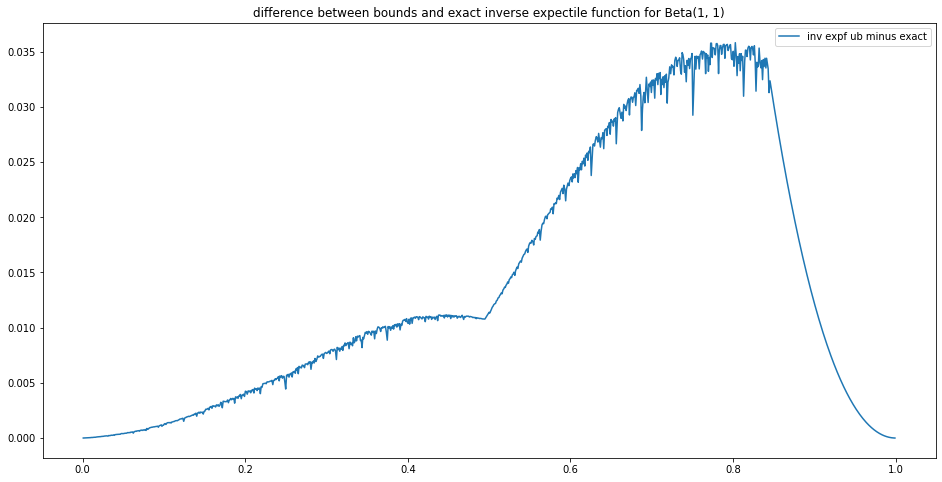

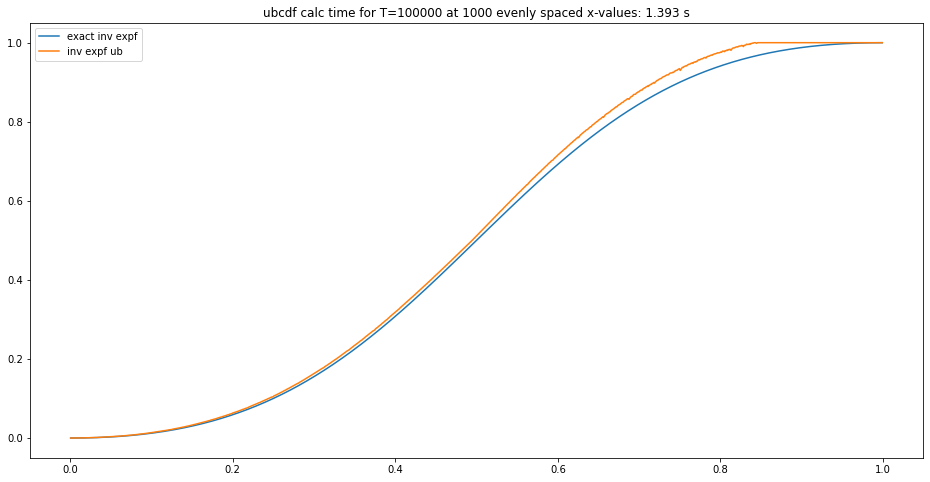

In [4]:
def flass(seed=4546):
    from scipy.special import betainc
    from numpy.random import default_rng

    betaa, betab = 1, 1
    T = 100000
    
    rng = default_rng(seed)
    data = rng.beta(betaa, betab, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    assert betab == 1
    true = Anon(desc = f'Beta({betaa}, {betab})',
                invexpectile = lambda slf, x: x**(1+betaa) / (betaa * (1 - x) + x * (2 * x**betaa - 1)),
               )
    
    plotit(data, true)

flass()

### Lognormal Distribution (supported on $[0, \infty)$)

mulower = 1.5890934509570407


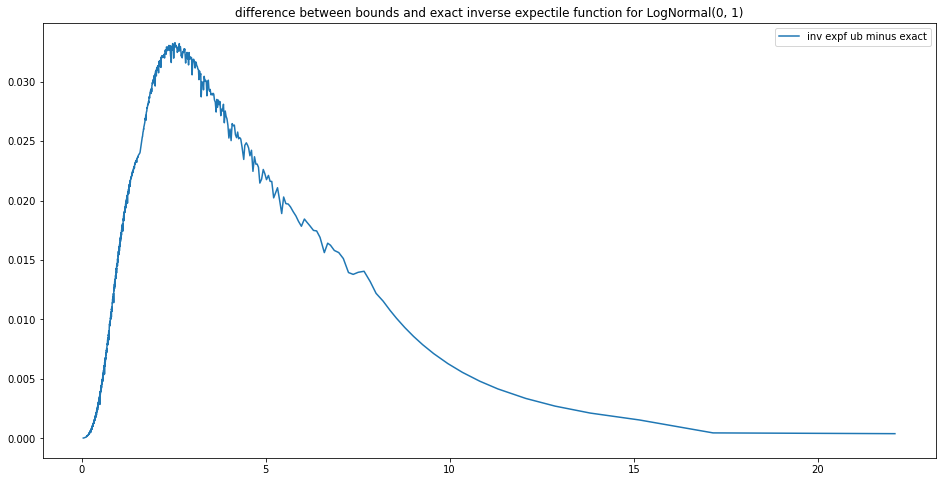

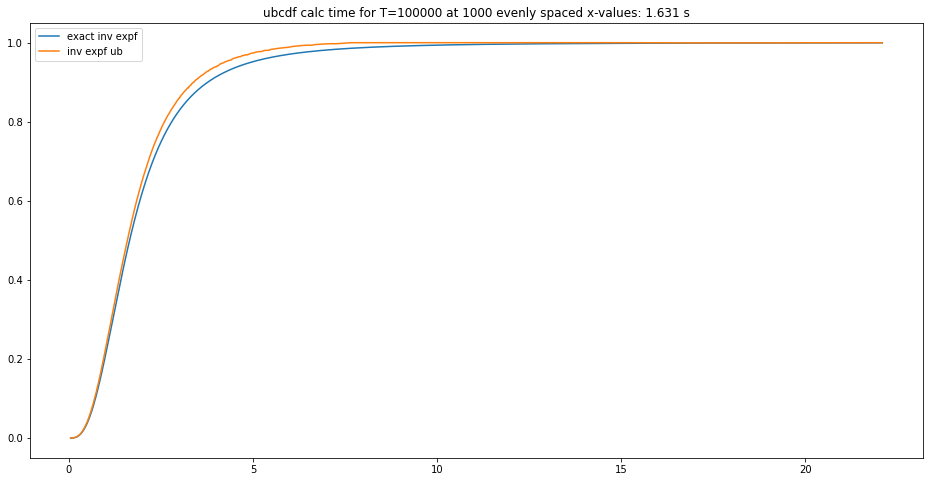

In [5]:
def flass(seed=4546):
    from math import erf, erfc, exp, log, sqrt
    from numpy.random import default_rng

    mu, sigma = 0, 1
    T = 100000
    
    rng = default_rng(seed)
    data = rng.lognormal(mu, sigma, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'LogNormal({mu}, {sigma})',
                invexpectile = lambda slf, v: (
                      ( (v * erfc( (mu - log(v)) / (sqrt(2) * sigma)) ) - exp(mu + sigma**2/2) * erfc( ( mu + sigma**2 - log(v) ) / (sqrt(2) * sigma) ) )
                    / ( (-2 * v * erf( (mu - log(v)) / (sqrt(2) * sigma)) ) + 2 * exp(mu + sigma**2/2) * erf( ( mu + sigma**2 - log(v) ) / (sqrt(2) * sigma) ) )
                   ),
               )
    
    plotit(data, true)

flass()